In [1]:
import torch
model = torch.hub.load('pytorch/vision:v0.4.2', 'squeezenet1_0', pretrained=True)
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import urllib
from PIL import Image
from torchvision import transforms

Using cache found in C:\Users\44754/.cache\torch\hub\pytorch_vision_v0.4.2


In [2]:
class LIME:
    def __init__(self,Image,Network,NumSuperpixels,NumSamples,LabelID):
        self.img = Image
        self.net = Network
        self.nsp = NumSuperpixels
        self.nss = NumSamples
        self.lid = LabelID
    def preprocess(self):
        preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)
        return input_batch
    def classify(self,xtensor):
        if torch.cuda.is_available():
            xtensor = xtensor.to('cuda')
            self.net.to('cuda')
        self.net.eval()
        with torch.no_grad():
            output = self.net(xtensor)
            out = torch.nn.functional.softmax(output, dim=1)
        return out
    def segmentdata(self):
        input_batch = self.preprocess()
        segments=slic(np.moveaxis(input_batch.squeeze().cpu().numpy(),0,-1),n_segments=self.nsp,sigma = 5)
        NumFeatures = len(np.unique(segments))
        NumRemainList=np.random.randint(1,NumFeatures,size=self.nss)
        segmentBinary = []
        for i in range(self.nss):
            tmpBinaryVec = np.zeros((1,NumFeatures))
            tmpNumRemain = NumRemainList[i]
            tmpRemainIdx = np.random.randint(NumFeatures,size=tmpNumRemain)
            tmpBinaryVec[:,tmpRemainIdx] = 1
            segmentBinary.append(tmpBinaryVec)
        return segments,np.array(segmentBinary).squeeze()
    def score(self,xtensor,segments,segmentBinary):
        for i in range(self.nss):
            RemainIdx = np.where(segmentBinary[i]==1)
            tmpMask = np.isin(segments,RemainIdx).reshape(1,1,224,224)
            tmpMask3= torch.from_numpy(np.tile(tmpMask,(1,3,1,1)))
            if i == 0:
                fudgedScores = self.classify(xtensor*tmpMask3)[:,self.lid]
            else:
                tmpfudgedScores = self.classify(xtensor*tmpMask3)[:,self.lid]
                fudgedScores = torch.cat([fudgedScores,tmpfudgedScores],dim=0)
        return fudgedScores.cpu().numpy()

## Import SqueezeNet, image and ImageNet labels

In [3]:
url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)
input_image = Image.open(filename)

In [4]:
lime = LIME(input_image,model,30,1024,258)
input_batch = lime.preprocess()
output = lime.classify(input_batch)

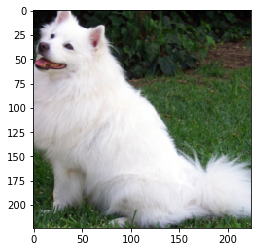

In [5]:
plt.imshow(np.moveaxis(input_batch.squeeze().cpu().numpy(),0,-1))

In [6]:
with open("imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read())
for idx in output[0].sort()[1][-5:]:
    print(str(idx.item())+': '+idx2label[idx.item()])

332: Angora, Angora rabbit
257: Great Pyrenees
157: papillon
279: Arctic fox, white fox, Alopex lagopus
258: Samoyed, Samoyede


## Superpixels

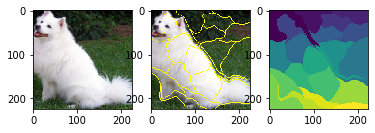

In [8]:
segments,segmentBinary = lime.segmentdata()
dispimg = np.moveaxis(input_batch.squeeze().cpu().numpy(),0,-1)
plt.subplot(1,3,1); plt.imshow(dispimg)
plt.subplot(1,3,2); plt.imshow(mark_boundaries(dispimg, segments))
plt.subplot(1,3,3); plt.imshow(segments)

## Local Interpretable Model-Agnostic Explanations (LIME)

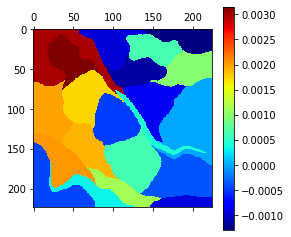

In [16]:
scores = lime.score(input_batch,segments,segmentBinary)
# Lasso
clf = Lasso(alpha=.00001)
clf.fit(segmentBinary,scores)
segmentImportance = clf.coef_
# Colormap of importance
mapWeight = np.zeros(segments.shape)
for i in range(len(np.unique(segments))):
    mapWeight[np.where(segments==i)] = segmentImportance[i] 
# Plot
plt.matshow(mapWeight)
plt.set_cmap('jet')
plt.colorbar()

## Result

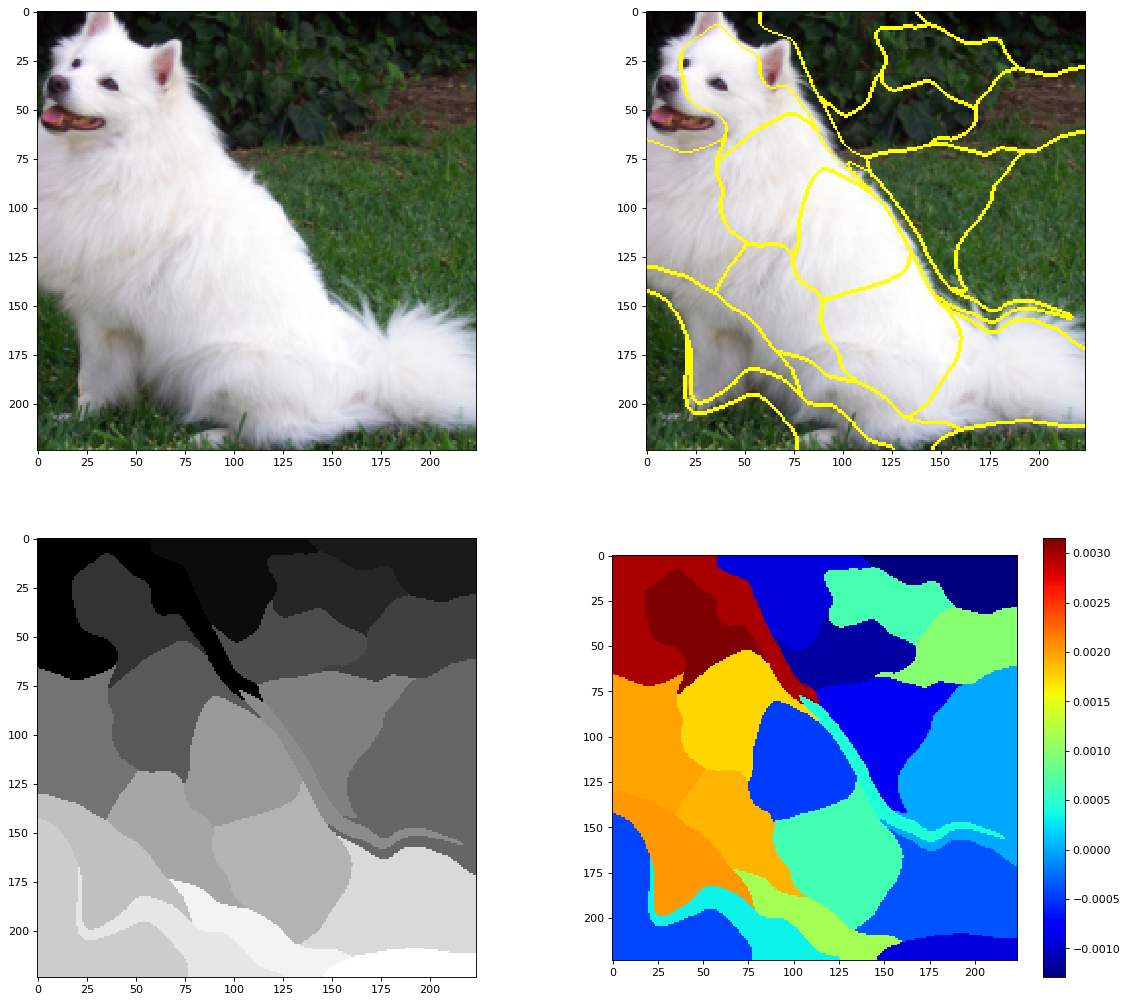

In [17]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,2,1); plt.imshow(dispimg)
plt.subplot(2,2,2); plt.imshow(mark_boundaries(dispimg, segments))
plt.subplot(2,2,3); plt.imshow(segments)
plt.set_cmap('gray')
plt.subplot(2,2,4)
plt.imshow(mapWeight)
plt.set_cmap('jet')
plt.colorbar()